<a href="https://colab.research.google.com/github/queens-supercluster/SpeechDiarization/blob/main/Wysdom_NVIDIA_NeMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
import os
import wget
import matplotlib.pyplot as plt

import nemo
import glob

import pprint
pp = pprint.PrettyPrinter(indent=4)

[NeMo W 2023-05-29 15:40:53 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-29 15:40:59 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [ ]:
import subprocess
import librosa
import numpy as np
from IPython.display import Audio

from google.colab import files
import os

uploaded = files.upload()
path = next(iter(uploaded))



Saving IR_200171179230220209-FL.wav to IR_200171179230220209-FL.wav


In [ ]:
# Extract the filename from the path
filename = os.path.basename(path)

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

# Move the uploaded file to the data directory
AUDIO_FILENAME = os.path.join(data_dir, filename)

audio_file_list = [os.path.join(data_dir, filename)]
print("Input audio file list:\n", audio_file_list)

# Convert the uploaded file to a seekable WAV format using FFmpeg
output_path = os.path.join(data_dir, 'audio.wav')
subprocess.call(['ffmpeg', '-i', os.path.join(data_dir, filename), output_path, '-y'])

AUDIO_FILENAME = output_path

# Load the seekable WAV file using librosa
signal, sample_rate = librosa.load(output_path, sr=None)

# Display the audio for verification
display(Audio(signal, rate=sample_rate))


Input audio file list:
 ['/content/data/IR_200171179230220209-FL.wav']


In [ ]:
data_dir

'/content/data'

In [ ]:
def display_waveform(signal,text='Audio',overlay_color=[]):
    fig,ax = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(2)
    plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c='k')
    if len(overlay_color):
        plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c=overlay_color)
    fig.suptitle(text, fontsize=16)
    plt.xlabel('time (secs)', fontsize=18)
    plt.ylabel('signal strength', fontsize=14);
    plt.axis([0,len(signal),-0.5,+0.5])
    time_axis,_ = plt.xticks();
    plt.xticks(time_axis[:-1],time_axis[:-1]/sample_rate);

COLORS="b g c m y".split()

def get_color(signal,speech_labels,sample_rate=16000):
    c=np.array(['k']*len(signal))
    for time_stamp in speech_labels:
        start,end,label=time_stamp.split()
        start,end = int(float(start)*16000),int(float(end)*16000),
        if label == "speech":
            code = 'red'
        else:
            code = COLORS[int(label.split('_')[-1])]
        c[start:end]=code

    return c

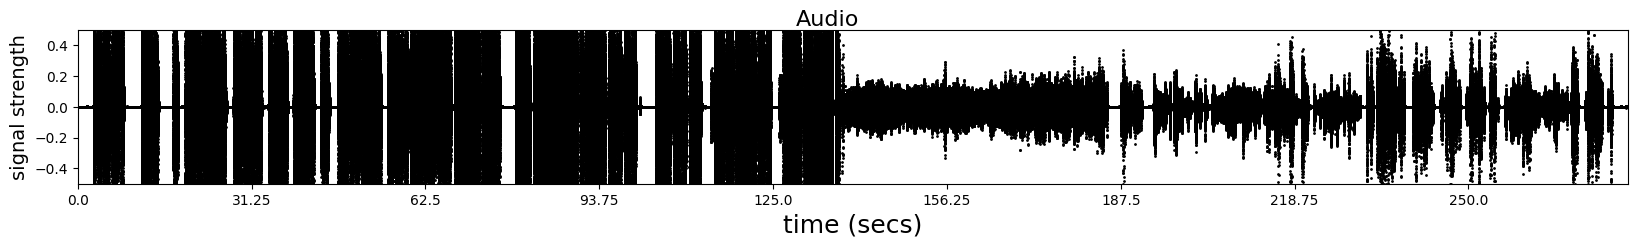

In [ ]:
display_waveform(signal)

In [ ]:
from omegaconf import OmegaConf
import shutil
DOMAIN_TYPE = "telephonic" # Can be meeting or telephonic based on domain type of the audio file
CONFIG_FILE_NAME = f"diar_infer_{DOMAIN_TYPE}.yaml"

CONFIG_URL = f"https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/{CONFIG_FILE_NAME}"

if not os.path.exists(os.path.join(data_dir,CONFIG_FILE_NAME)):
    CONFIG = wget.download(CONFIG_URL, data_dir)
else:
    CONFIG = os.path.join(data_dir,CONFIG_FILE_NAME)

cfg = OmegaConf.load(CONFIG)
print(OmegaConf.to_yaml(cfg))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: null
verbose: true
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max

In [ ]:
# Create a manifest file for input with below format.
# {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-",
# "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
import json
meta = {
    'audio_filepath': AUDIO_FILENAME,
    'offset': 0,
    'duration':None,
    'label': 'infer',
    'text': '-',
    'num_speakers': None,
    'rttm_filepath': None,
    'uem_filepath' : None
}
with open(os.path.join(data_dir,'input_manifest.json'),'w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

cfg.diarizer.manifest_filepath = os.path.join(data_dir,'input_manifest.json')
!cat {cfg.diarizer.manifest_filepath}

{"audio_filepath": "/content/data/audio.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": null, "uem_filepath": null}


In [ ]:
pretrained_speaker_model='titanet_large'
cfg.diarizer.manifest_filepath = cfg.diarizer.manifest_filepath
cfg.diarizer.out_dir = data_dir #Directory to store intermediate files and prediction outputs
cfg.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
cfg.diarizer.clustering.parameters.oracle_num_speakers=False

# Using Neural VAD and Conformer ASR
cfg.diarizer.vad.model_path = 'vad_telephony_marblenet'
cfg.diarizer.asr.model_path = 'stt_en_conformer_ctc_large'

cfg.diarizer.asr.parameters.asr_based_vad = False

In [ ]:
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASRDecoderTimeStamps
asr_decoder_ts = ASRDecoderTimeStamps(cfg.diarizer)
asr_model = asr_decoder_ts.set_asr_model()
word_hyp, word_ts_hyp = asr_decoder_ts.run_ASR(asr_model)

[NeMo I 2023-05-29 15:50:26 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-29 15:50:26 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
[NeMo I 2023-05-29 15:50:26 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo
[NeMo I 2023-05-29 15:50:26 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-05-29 15:50:29 mixins:170] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2023-05-29 15:50:29 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket1/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket2/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket3/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket4/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket5/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket6/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket7/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_

[NeMo I 2023-05-29 15:50:29 features:291] PADDING: 0
[NeMo I 2023-05-29 15:50:31 save_restore_connector:249] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0rc0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.


[NeMo W 2023-05-29 15:50:31 decoder_timestamps_utils:66] `ctc_decode` was set to True. Note that this is ignored.


[NeMo I 2023-05-29 15:50:31 features:291] PADDING: 0
[NeMo I 2023-05-29 15:50:31 features:291] PADDING: 0


[NeMo W 2023-05-29 15:50:31 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2023-05-29 15:50:31 decoder_timestamps_utils:651] Running ASR model stt_en_conformer_ctc_large
[NeMo I 2023-05-29 15:50:31 decoder_timestamps_utils:655] [1/1] FrameBatchASR: /content/data/audio.wav


In [ ]:
print("Decoded word output dictionary: \n", word_hyp['audio'])
print("Word-level timestamps dictionary: \n", word_ts_hyp['audio'])

Decoded word output dictionary: 
 ['welcome', 'to', 'hydro', 'one', 'pu', 'contu', 'francis', 'seco', 'de', 'udit', 'francais', 'please', 'note', 'your', 'call', 'will', 'be', 'recorded', 'for', 'quality', 'assurance', 'main', 'menu', 'if', "you're", 'calling', 'about', 'a', 'power', 'outage', 'down', 'line', 'or', 'for', 'any', 'other', 'power', 'problem', 'press', 'one', 'or', 'say', 'outage', 'for', 'billing', 'and', 'payment', 'matters', 'press', 'to', 'or', 'say', 'billing', 'or', 'payment', 'if', "you're", 'moving', 'press', 'three', 'or', 'say', 'moving', 'for', 'all', 'other', 'services', 'press', 'for', 'or', 'say', 'other', 'to', 'repeat', 'these', 'options', 'that', 'response', "wasn't", 'recognized', 'your', 'menu', 'options', 'will', 'be', 'repeated', 'if', "you're", 'calling', 'about', 'a', 'power', 'at', 'all', 'other', 'services', 'menu', 'to', 'enter', 'a', 'meter', 'reading', 'press', 'one', 'or', 'say', 'reading', 'for', 'new', 'construction', 'or', 'to', 'make', 'a'

In [ ]:
from nemo.collections.asr.parts.utils.diarization_utils import OfflineDiarWithASR
asr_diar_offline = OfflineDiarWithASR(cfg.diarizer)
asr_diar_offline.word_ts_anchor_offset = asr_decoder_ts.word_ts_anchor_offset

[NeMo I 2023-05-29 15:59:00 speaker_utils:93] Number of files to diarize: 1


In [ ]:
diar_hyp, diar_score = asr_diar_offline.run_diarization(cfg, word_ts_hyp)
print("Diarization hypothesis output: \n", diar_hyp['audio'])

[NeMo I 2023-05-29 15:03:31 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2023-05-29 15:03:31 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/vad_multilingual_marblenet/versions/1.10.0/files/vad_multilingual_marblenet.nemo to /root/.cache/torch/NeMo/NeMo_1.19.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2023-05-29 15:03:33 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-29 15:03:33 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2023-05-29 15:03:33 features:291] PADDING: 16
[NeMo I 2023-05-29 15:03:33 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2023-05-29 15:03:33 clustering_diarizer:157] Loading pretrained titanet_large model from NGC
[NeMo I 2023-05-29 15:03:33 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/titanet_large/versions/v1/files/titanet-l.nemo to /root/.cache/torch/NeMo/NeMo_1.19.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2023-05-29 15:03:38 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-05-29 15:03:38 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-05-29 15:03:38 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-05-29 15:03:38 features:291] PADDING: 16
[NeMo I 2023-05-29 15:03:39 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.
[NeMo I 2023-05-29 15:03:39 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2023-05-29 15:03:39 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 274.16it/s]

[NeMo I 2023-05-29 15:03:39 classification_models:268] Perform streaming frame-level VAD
[NeMo I 2023-05-29 15:03:39 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:39 collections:299] Dataset loaded with 1 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:39 collections:301] # 1 files loaded accounting to # 1 labels



vad: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[NeMo I 2023-05-29 15:03:40 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.



creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

[NeMo I 2023-05-29 15:03:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/data/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-29 15:03:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:40 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:40 collections:299] Dataset loaded with 3 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:40 collections:301] # 3 files loaded accounting to # 1 labels



[1/6] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

[NeMo I 2023-05-29 15:03:41 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings
[NeMo I 2023-05-29 15:03:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/data/speaker_outputs/subsegments_scale1.json
[NeMo I 2023-05-29 15:03:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:41 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:41 collections:299] Dataset loaded with 4 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:41 collections:301] # 4 files loaded accounting to # 1 labels



[2/6] extract embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

[NeMo I 2023-05-29 15:03:42 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings
[NeMo I 2023-05-29 15:03:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/data/speaker_outputs/subsegments_scale2.json
[NeMo I 2023-05-29 15:03:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:42 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:42 collections:299] Dataset loaded with 5 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:42 collections:301] # 5 files loaded accounting to # 1 labels



[3/6] extract embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

[NeMo I 2023-05-29 15:03:44 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings
[NeMo I 2023-05-29 15:03:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/data/speaker_outputs/subsegments_scale3.json
[NeMo I 2023-05-29 15:03:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:44 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:44 collections:299] Dataset loaded with 6 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:44 collections:301] # 6 files loaded accounting to # 1 labels



[4/6] extract embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

[NeMo I 2023-05-29 15:03:46 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings
[NeMo I 2023-05-29 15:03:46 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/data/speaker_outputs/subsegments_scale4.json
[NeMo I 2023-05-29 15:03:46 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:46 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:46 collections:299] Dataset loaded with 10 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:46 collections:301] # 10 files loaded accounting to # 1 labels



[5/6] extract embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

[NeMo I 2023-05-29 15:03:48 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings
[NeMo I 2023-05-29 15:03:48 clustering_diarizer:287] Subsegmentation for embedding extraction: scale5, /content/data/speaker_outputs/subsegments_scale5.json
[NeMo I 2023-05-29 15:03:48 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2023-05-29 15:03:48 collections:298] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2023-05-29 15:03:48 collections:299] Dataset loaded with 20 items, total duration of  0.00 hours.
[NeMo I 2023-05-29 15:03:48 collections:301] # 20 files loaded accounting to # 1 labels



[6/6] extract embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

[NeMo I 2023-05-29 15:03:50 clustering_diarizer:389] Saved embedding files to /content/data/speaker_outputs/embeddings



[NeMo W 2023-05-29 15:03:51 speaker_utils:464] cuda=False, using CPU for eigen decomposition. This might slow down the clustering process.
clustering: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

[NeMo I 2023-05-29 15:03:52 clustering_diarizer:464] Outputs are saved in /content/data directory



[NeMo W 2023-05-29 15:03:52 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


Diarization hypothesis output: 
 ['0.07 2.695 speaker_0', '2.695 5.199999999999999 speaker_1']


[   'SPEAKER an4_diarize_test 1   0.070   2.625 <NA> <NA> speaker_0 <NA> <NA>',
    'SPEAKER an4_diarize_test 1   2.695   2.505 <NA> <NA> speaker_1 <NA> <NA>']


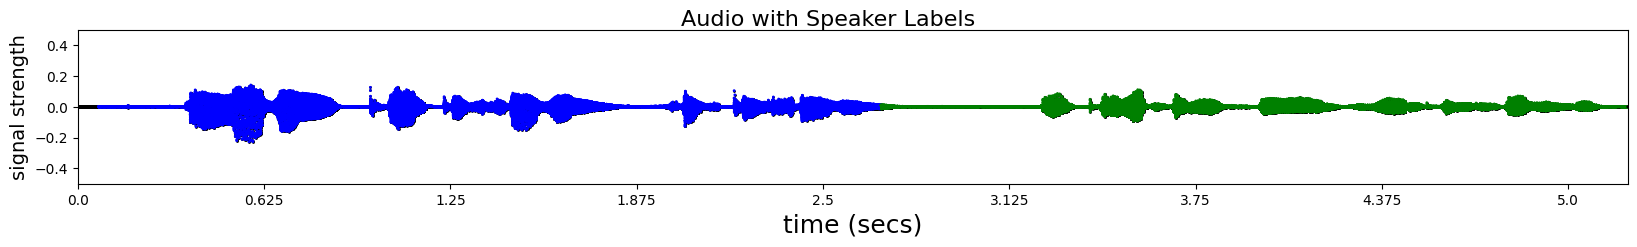

In [ ]:
def read_file(path_to_file):
    with open(path_to_file) as f:
        contents = f.read().splitlines()
    return contents

predicted_speaker_label_rttm_path = f"{data_dir}/pred_rttms/an4_diarize_test.rttm"
pred_rttm = read_file(predicted_speaker_label_rttm_path)

pp.pprint(pred_rttm)

from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels
pred_labels = rttm_to_labels(predicted_speaker_label_rttm_path)

color = get_color(signal, pred_labels)
display_waveform(signal,'Audio with Speaker Labels', color)
display(Audio(signal,rate=16000))

In [ ]:
trans_info_dict = asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

[NeMo I 2023-05-29 15:04:39 diarization_utils:876] Creating results for Session: an4_diarize_test n_spk: 2 
[NeMo I 2023-05-29 15:04:39 diarization_utils:749] Diarization with ASR output files are saved in: /content/data/pred_rttms


In [ ]:
transcription_path_to_file = f"{data_dir}/pred_rttms/an4_diarize_test.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   '[00:00.07 - 00:02.60] speaker_0: eleven twenty seven fifty seven',
    '[00:03.08 - 00:05.16] speaker_1: october twenty four nineteen seventy']


In [ ]:
transcription_path_to_file = f"{data_dir}/pred_rttms/an4_diarize_test.json"
json_contents = read_file(transcription_path_to_file)
pp.pprint(json_contents)

[   '{',
    '    "status": "success",',
    '    "session_id": "an4_diarize_test",',
    '    "transcription": "eleven twenty seven fifty seven october twenty four '
    'nineteen seventy",',
    '    "speaker_count": 2,',
    '    "words": [',
    '        {',
    '            "word": "eleven",',
    '            "start_time": 0.4,',
    '            "end_time": 0.72,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "twenty",',
    '            "start_time": 0.92,',
    '            "end_time": 1.28,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "seven",',
    '            "start_time": 1.4,',
    '            "end_time": 1.64,',
    '            "speaker": "speaker_0"',
    '        },',
    '        {',
    '            "word": "fifty",',
    '            "start_time": 1.96,',
    '            "end_time": 2.28,',
    '            "speaker": "speaker_0"',
    '        },'